 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
# !pip install torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [304]:
import torch
from torchvision import datasets, transforms
import helper

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

trainset = datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = datasets.FashionMNIST(root='./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [305]:
classes = {idx:name for idx,name in enumerate(trainloader.dataset.classes)}
classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [306]:
print(f"В train {len(trainset)} картинок\nВ test {len(testset)} картинок")

В train 60000 картинок
В test 10000 картинок


In [307]:
np.unique(trainset.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [308]:
np.unique(testset.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

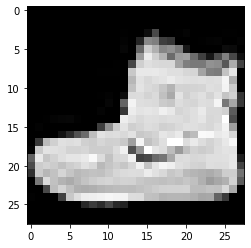

In [309]:
plt.imshow(trainloader.dataset.data[0].numpy(),  cmap='gray')

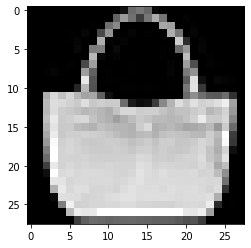

In [310]:
plt.imshow(trainloader.dataset.data[100].numpy(),  cmap='gray')

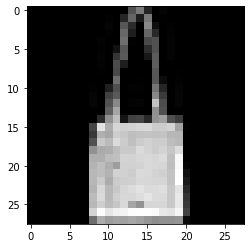

In [311]:
plt.imshow(trainloader.dataset.data[200].numpy(), cmap='gray')

In [10]:
from torch import nn, optim
import torch.nn.functional as F


In [298]:
def view_classify(img, ps, labl, one=True):
    pred = classes[ps]
    real = classes[labl.item()] 
    if one:
      print("Predicted class:", pred, " Real class: ", real)
      plt.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
      return
    return pred == real

In [301]:
def show_accuracy(typeset, dataset, model, classes, modelname):
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  with torch.no_grad():
    for images, labels in dataset:
      if modelname == "model_cnn":
        test = images
        outputs = model_cnn(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        for i in range(100):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1
      else:
        for i, j in zip(images, labels):
          img = i
          labl = j
          ps = np.argmax(torch.exp(model(img)).data.numpy().squeeze())
          res = view_classify(img, ps, labl, one=False)
          class_correct[labl] += res
          class_total[labl] += 1
  print(modelname + ":")
  ans = []
  for i in range(10):
      print('Accuracy of %5s : %2d %% on %5s' % (
          classes[i], 100 * class_correct[i] / class_total[i], typeset))
      ans.append(100 * class_correct[i] / class_total[i])
  print("Mean accuracy: ", sum(ans)/len(ans), "%")


In [98]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [18]:
model_mlp = MLP()

In [19]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_mlp.parameters())
epochs = 20
loss_array = []
for e in range(epochs):
    running_loss = []
    for images, labels in trainloader:
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        log_ps = model_mlp(images)
        
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    loss_array.append(sum(running_loss)/len(trainloader))
    print("Epoch: ", e)
    print(f"Training loss: {sum(running_loss)/len(trainloader)}")

Epoch:  0
Training loss: 0.529956910337011
Epoch:  1
Training loss: 0.37795245366791885
Epoch:  2
Training loss: 0.3370088710139195
Epoch:  3
Training loss: 0.31387791809936366
Epoch:  4
Training loss: 0.29293280851095915
Epoch:  5
Training loss: 0.2796983220304052
Epoch:  6
Training loss: 0.2651986574133237
Epoch:  7
Training loss: 0.2552326984206835
Epoch:  8
Training loss: 0.24086765861759582
Epoch:  9
Training loss: 0.23213643794258434
Epoch:  10
Training loss: 0.22191535675898194
Epoch:  11
Training loss: 0.21440764546394347
Epoch:  12
Training loss: 0.20584534282485645
Epoch:  13
Training loss: 0.1947432473798593
Epoch:  14
Training loss: 0.1851628368223707
Epoch:  15
Training loss: 0.17866236522172887
Epoch:  16
Training loss: 0.17112921288857857
Epoch:  17
Training loss: 0.16931339455768465
Epoch:  18
Training loss: 0.15757040148600937
Epoch:  19
Training loss: 0.1523498854848246


In [302]:
show_accuracy('train', trainloader, model=model_mlp, classes=classes, modelname='model_mlp')

model_mlp:
Accuracy of T-shirt/top : 94 % on train
Accuracy of Trouser : 99 % on train
Accuracy of Pullover : 95 % on train
Accuracy of Dress : 95 % on train
Accuracy of  Coat : 90 % on train
Accuracy of Sandal : 99 % on train
Accuracy of Shirt : 80 % on train
Accuracy of Sneaker : 97 % on train
Accuracy of   Bag : 99 % on train
Accuracy of Ankle boot : 98 % on train
Mean accuracy:  95.12333333333333 %


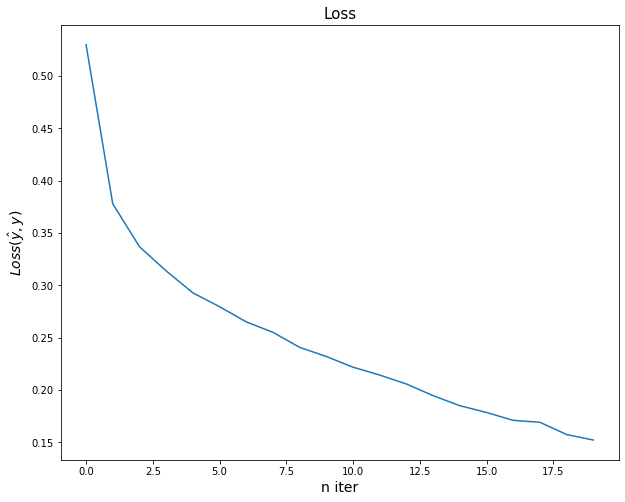

CPU times: user 290 ms, sys: 18.3 ms, total: 308 ms
Wall time: 290 ms


In [105]:
%%time
plt.figure(figsize=(10, 8))
plt.plot(loss_array)
plt.title('Loss', fontsize=15)
plt.xlabel('n iter', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [41]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.log_softmax(self.fc3(out), dim=1)

        
        return out

In [43]:
model_cnn = CNN()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_cnn.parameters())
epochs = 20
loss_array_cnn = []
for e in range(epochs):
    running_loss = []
    for images, labels in trainloader:
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        log_ps = model_cnn(images)
        
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    loss_array_cnn.append(sum(running_loss)/len(trainloader))
    print("Epoch: ", e)
    print(f"Training loss: {sum(running_loss)/len(trainloader)}")

Epoch:  0
Training loss: 0.43826928262909254
Epoch:  1
Training loss: 0.3021020786464214
Epoch:  2
Training loss: 0.2668050181120634
Epoch:  3
Training loss: 0.2384338751559456
Epoch:  4
Training loss: 0.2217475930849711
Epoch:  5
Training loss: 0.20512134220451117
Epoch:  6
Training loss: 0.1911690596366922
Epoch:  7
Training loss: 0.17410619103039304
Epoch:  8
Training loss: 0.1680180785494546
Epoch:  9
Training loss: 0.15445850336303313
Epoch:  10
Training loss: 0.14547138154506684
Epoch:  11
Training loss: 0.13682512229308486
Epoch:  12
Training loss: 0.1293798068103691
Epoch:  13
Training loss: 0.12311783825357756
Epoch:  14
Training loss: 0.1150191511431088
Epoch:  15
Training loss: 0.11160965107381343
Epoch:  16
Training loss: 0.10498988054382305
Epoch:  17
Training loss: 0.09913497811183333
Epoch:  18
Training loss: 0.0933399974834174
Epoch:  19
Training loss: 0.09109814984413485


In [117]:
show_accuracy('train', trainloader, model=model_cnn, classes=classes, modelname="model_cnn")

model_cnn:
Accuracy of T-shirt/top : 92 % on train
Accuracy of Trouser : 99 % on train
Accuracy of Pullover : 96 % on train
Accuracy of Dress : 96 % on train
Accuracy of  Coat : 95 % on train
Accuracy of Sandal : 99 % on train
Accuracy of Shirt : 95 % on train
Accuracy of Sneaker : 99 % on train
Accuracy of   Bag : 99 % on train
Accuracy of Ankle boot : 99 % on train
Mean accuracy:  97.455 %


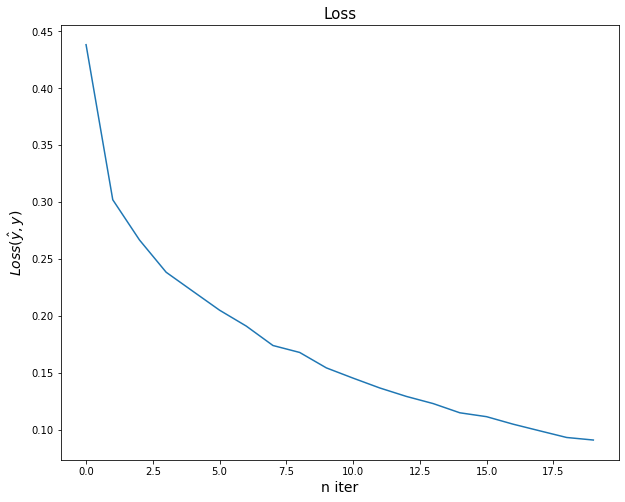

CPU times: user 243 ms, sys: 7.04 ms, total: 251 ms
Wall time: 246 ms


In [108]:
%%time
plt.figure(figsize=(10, 8))
plt.plot(loss_array_cnn)
plt.title('Loss', fontsize=15)
plt.xlabel('n iter', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [106]:
show_accuracy('test', testloader, model=model_mlp, classes=classes, modelname="model_mlp")

model_mlp:
Accuracy of T-shirt/top : 87 % on  test
Accuracy of Trouser : 97 % on  test
Accuracy of Pullover : 87 % on  test
Accuracy of Dress : 89 % on  test
Accuracy of  Coat : 80 % on  test
Accuracy of Sandal : 95 % on  test
Accuracy of Shirt : 66 % on  test
Accuracy of Sneaker : 94 % on  test
Accuracy of   Bag : 96 % on  test
Accuracy of Ankle boot : 95 % on  test
Mean accuracy:  89.14 %


In [118]:
show_accuracy('test', testloader, model=model_cnn, classes=classes, modelname="model_cnn")

model_cnn:
Accuracy of T-shirt/top : 81 % on  test
Accuracy of Trouser : 97 % on  test
Accuracy of Pullover : 86 % on  test
Accuracy of Dress : 88 % on  test
Accuracy of  Coat : 85 % on  test
Accuracy of Sandal : 96 % on  test
Accuracy of Shirt : 78 % on  test
Accuracy of Sneaker : 97 % on  test
Accuracy of   Bag : 97 % on  test
Accuracy of Ankle boot : 97 % on  test
Mean accuracy:  90.67 %


Вывод: У MLP существует проблема отличить футболку от пулловера, пальто и рубашки. В остальном модель справляется хорошо, имея среднее accuracy 89.14 %.
CNN же справилась лучше, показав результат 90.67 %. Также по графикам видно, что CNN пришла к меньшему, чем MLP, показателю потерь за одинаковое число эпох и при одинаковых параметрах оптимизатора. 

Также прищла идея сделать тест предсказания на полученных моделях

Predicted class: Coat  Real class:  Coat


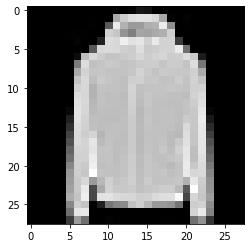

In [299]:
images, labels = next(iter(testloader))
i = np.random.randint(0, len(labels))
img = images[i]
labels = labels[i]
ps = torch.exp(model_mlp(img)).data.numpy().squeeze()
pred = np.argmax(ps)
view_classify(img, pred, labels, one=True)

Predicted class: Trouser  Real class:  Trouser


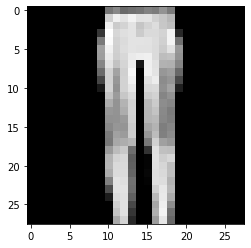

In [300]:
images, labels = next(iter(testloader))
i = np.random.randint(0, len(labels))
img = images[i]
label = labels[i]
ps = torch.max(model_cnn(images), 1)[1]
pred = ps[i].item()
view_classify(img, pred, label, one=True)